# Business Case 1

Group members:
- Lorenzo Pigozzi	--- m20200745
- Nguyen Huy Phuc	--- m20200566
- Ema Mandura	  --- m20200647


## Hotel

- **Predictive model objectives:**
    - Forecast net demand based on reservations
    - Pricing strategy and overbooking policies
    - Identifying high potential in cancellation customers


<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Importing data and libraries](#1)   
2.	[Exploratory data analysis (EDA)](#2)       
3.	[Data preprocessing](#3)  
4.  [Cluster analysis](#4)      
5.  [Merging the results](#5)

# 1. Importing data and libraries <a class="anchor" id="1"></a>

In [2]:
import numpy as np
import pandas as pd
import math
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from joblib import dump
import time
# Sklearn
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score,auc, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
#sklearn categorical encoding
import category_encoders as ce
#sklearn modelling
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
#saving model and encoder
import pickle
#Light GBM
import lightgbm as lgb



#PROJECT_ROOT = Path(os.path.abspath('')).resolve()
#warnings
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True


In [3]:
data = pd.read_csv('data/H2.csv')

In [4]:
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,...,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,...,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,...,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [5]:
# remove all the unwanted spaces in the data
data.loc[:,data.dtypes == "O"] = data.loc[:,data.dtypes == "O"].apply(lambda x : x.str.strip())

In [6]:
numeric_feats = data.loc[:,data.dtypes != "O"].columns.drop('IsCanceled')
cat_feats = data.loc[:,data.dtypes == "O"].columns
target = 'IsCanceled'

# 2. Exploratory data analysis (EDA) <a class="anchor" id="2"></a>

In [7]:
#find features with correlations greater than 0.9 in order to remove them
def correlation_check(df, limit = 0.90, drop = False):
    corr = df.corr()
    mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
    corr_no_diag = corr.where(mask)
    coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]        
    #df.drop(coll,axis = 1,inplace=True)
    print('High correlation columns are:', coll)
def corrheatmap(dataframe):
    sns.set(style="whitegrid")
    # Compute the correlation matrix
    corr = dataframe.corr() #Getting correlation of numerical variables
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 8))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, annot=True,annot_kws={"fontsize":10}, linewidths=.5,vmin = -1, vmax = 1, ax=ax)
    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

def boxplot_withoutLabels(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(y=df.loc[:,i[1]], ax=i[0], color='r')      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)

    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def displot_all(df, columns, target):
    #Prepare figure layout
    rows = int(math.ceil(columns.shape[0]/5))
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=5, figsize=(15,3*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), columns):
        sns.histplot(x=df.loc[:,i[1]], ax=i[0], hue = df[target],palette="icefire")      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        i[0].set_xlabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Dist plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def countplot_all(df, columns):
    #Prepare figure layout
    rows = int(math.ceil(columns.shape[0]/5))
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=5, figsize=(15,3*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), columns):
        sns.countplot(x=df.loc[:,i[1]], ax=i[0],palette="icefire")      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        i[0].set_xlabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Count plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def corrheatmap(dataframe, method = "pearson"):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr(method= method) #Getting correlation of numerical variables

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 16))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True,annot=True, linewidths=.5,vmin = -1, vmax = 1, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0, fontsize = 14)
    plt.xticks(rotation=90, fontsize = 14)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()      
    
def weight_of_variable(df, column, target, plot = True, sortby = 'Total count'):
    # Count total observations
    total = df[[column, target]].groupby(by = column,).count().sort_values(by = target, ascending = False)

    # Count
    with_target = df[[column, target]].groupby(by = column).sum().sort_values(by = target, ascending = False)
    
    weight = (df[[column, target]].groupby(by = column).sum().sort_values(by = target, ascending = False) / 
    (df[[column, target]].groupby(by = column).count().sort_values(by = target, ascending = False))).sort_values(by = target, ascending = False)
    
    concat_df = pd.concat([total, with_target, weight],axis = 1)
    
    out = pd.DataFrame(concat_df.values,index=concat_df.index, columns=['Total count', 'Cancelled count', 'Weight'])
    # Explore feature vs target by catplot
    if plot == True:
        g = sns.catplot(x=target,y=column,data=df,kind="bar", size = 4 , palette = "icefire",orient='h',height=.5, aspect=2)
        #g.set(ylim=(lower, upper)) 
        g.despine(left=True)
        g.fig.set_figwidth(8)
        g.fig.set_figheight(3*ceil(len(df[column].unique())/10))
        g.set_ylabels("Categories")
        # Rotate the labels
        for ax in g.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(-45)

    return out.astype({'Total count':'int', 'Cancelled count':'int64'}).sort_values(by = sortby ,ascending = False)

## 2.1. Clean data

### Check for missing values:

In [8]:
data.isna().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
Agent                           0
Company                         0
DaysInWaitingList               0
CustomerType                    0
ADR                             0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationSta

In [9]:
data.dropna(inplace=True)

The amount of missing data is too few to create damage to the model. Thus, we decided to drop them.

### Checking duplicated observations

In [10]:
# Checking duplicated observations
data.loc[data.duplicated(keep=False), :]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
8,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
9,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
10,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
12,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
17,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79292,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79293,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79294,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79312,0,175,2017,August,35,31,1,3,1,0.0,...,No Deposit,42,NULL,0,Transient,82.35,0,1,Check-Out,2017-09-04


There are a lot of duplicate observations in the dataset. However, since we can not explicitly prove that these observation are whether duplicated or coincident. We will keep all these duplicated values and accepted them as odds

### Check for variables univariate distribution

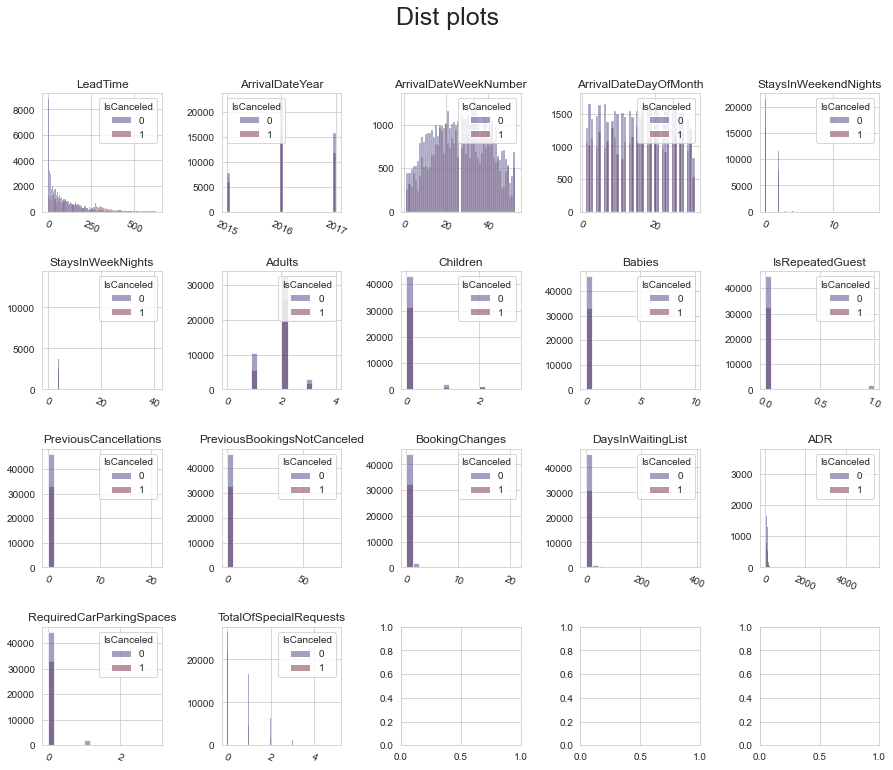

In [11]:
displot_all(data,numeric_feats,target=target)  

A lot of features have outliners, I think in the next EDA steps, we should divide the features by their charatacteristics and try to understand them

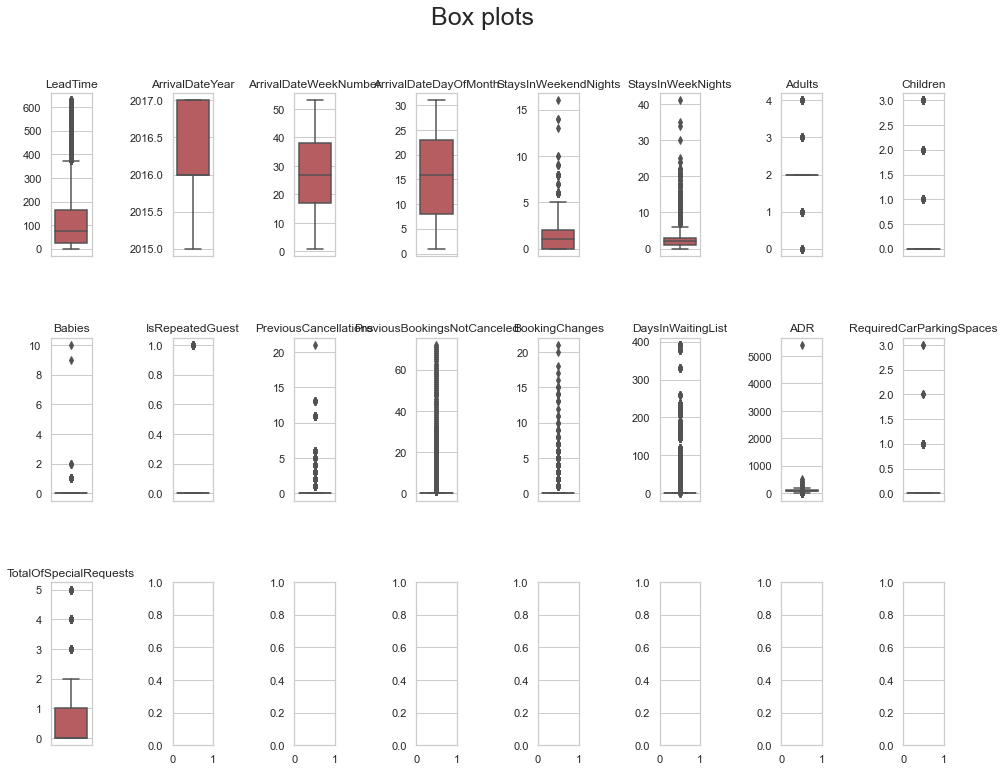

In [12]:
boxplot_withoutLabels(data[numeric_feats])

### Checking outliers of `ADR` 

<AxesSubplot:xlabel='ADR'>

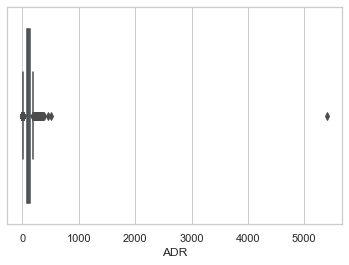

In [13]:
sns.boxplot(data=data,x = "ADR", hue = "IsCanceled")

In [14]:
data[data['ADR'] >1000]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
8455,1,35,2016,March,13,25,0,1,2,0.0,...,Non Refund,12,NULL,0,Transient,5400.0,0,0,Canceled,2016-02-19


`ADR` feature have an outlier of more than 5000 values of ADR, we will remove from the model as this is an abnomalie that will harm the performance of the model

In [15]:
outlier_index = data[data['ADR'] >1000].index

### Checking outliers of `Babies` 

<AxesSubplot:xlabel='Babies'>

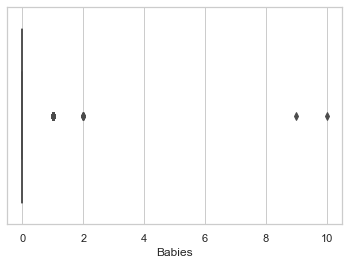

In [16]:
sns.boxplot(data=data,x = "Babies", hue = "IsCanceled")

In [17]:
data[data['Babies'] >4]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
6559,0,37,2016,January,3,12,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,84.45,0,1,Check-Out,2016-01-14
38596,0,11,2015,October,42,11,2,1,1,0.0,...,No Deposit,95,NULL,0,Transient-Party,95.00,0,0,Check-Out,2015-10-14


There is only 2 outliers in this feature and they are intuitively considered as outlier. We will also consider to remove them

In [18]:
outlier_index = outlier_index.append(data[data['Babies'] >4].index)

In [27]:
# remove the outliers
data.drop(index=outlier_index,inplace=True,errors='ignore')

## 2.2. Explore variables

### Will leadtime of bookings affect the cancelation rate?

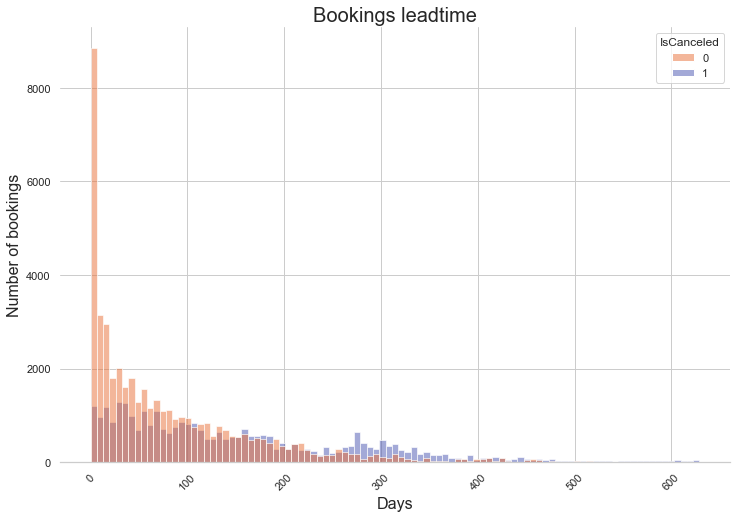

In [109]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.histplot(data=data, x="LeadTime", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)])
sns.despine(left=True)
plt.title("Bookings leadtime", fontsize=20)
plt.xlabel("Days", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
#plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

Most of booking for more than 275 days ahead will be canceled. Bookings at 1 day before the arrival has lowest probability of cancelation

### Categorical features distribution

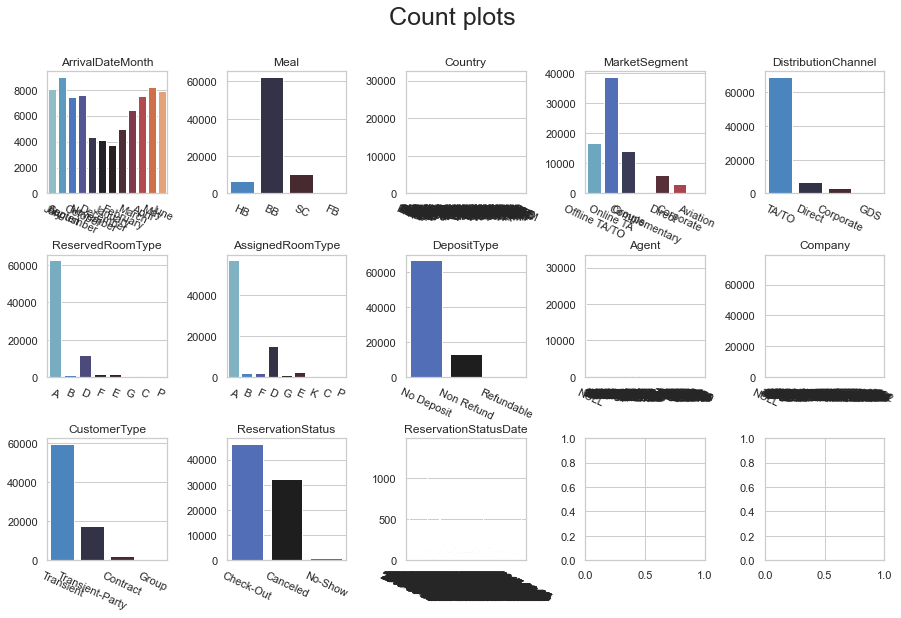

In [19]:
countplot_all(data,cat_feats)

### Reservation Status

,Total count,Cancelled count,Weight
Check-Out,46226,0,0.0
Canceled,32160,32160,1.0
No-Show,916,916,1.0


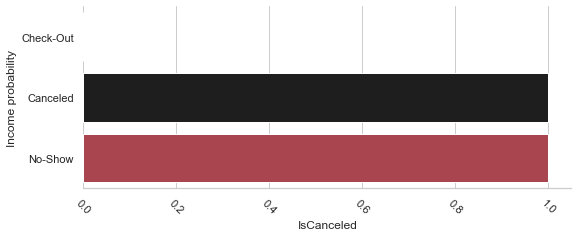

In [20]:
weight_of_variable(data,"ReservationStatus",target)

This features must be removed because it is only available after the customer cancelled. Therefore, having this feature is an target leakage in the model training. The same happens with `ResearvationStatusDate`, which will also be removed

### Customers' country of origin

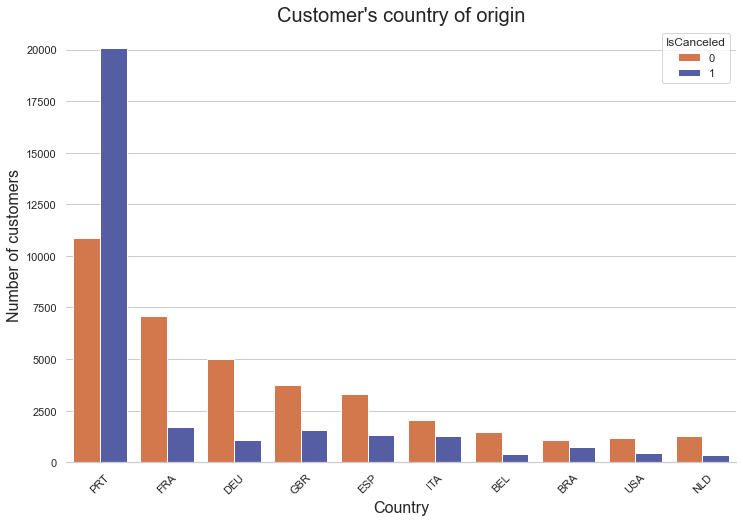

In [46]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=data, x="Country", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)],
              order = pd.value_counts(data['Country']).iloc[:10].index)
sns.despine(left=True)
plt.title("Customer's country of origin", fontsize=20)
plt.xlabel("Country", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of customers", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

From the plot above, there are 2 main points need to be pointed out. The first one is that the customers of the hotel mostly come from Portugal, which is quite obvious as the hotel is in Portugal. However, the second point is that the number of canceled bookings from Portugal is extremely high, nearly double the number of confirmed bookings

### Analyse the time patterns in customer bookings

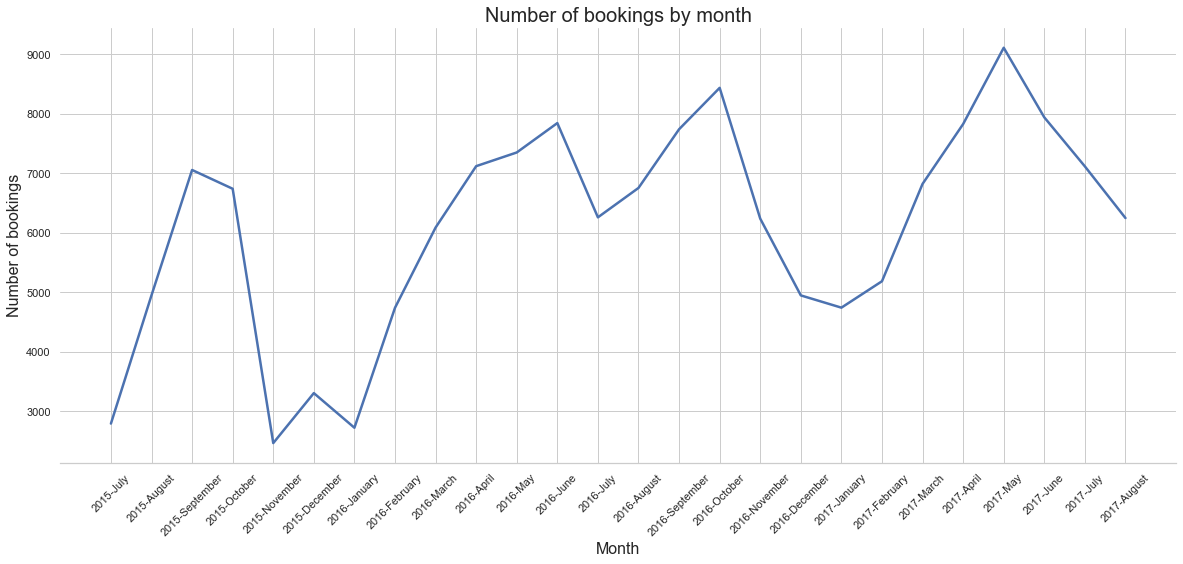

In [90]:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

plt_df = data[['ArrivalDateMonth','ArrivalDateYear']].sort_values('ArrivalDateMonth')
plt_df["ArrivalDateMonth"] = pd.Categorical(plt_df["ArrivalDateMonth"], categories=ordered_months, ordered=True)
plt_df = plt_df.pivot_table(index=['ArrivalDateYear','ArrivalDateMonth'], aggfunc=np.count_nonzero)
plt_df.index = plt_df.index.map('{0[0]}-{0[1]}'.format)
# show figure:
plt.figure(figsize=(20, 8))
sns.lineplot(data=plt_df, palette="icefire", linewidth=2.5,dashes=False)
sns.despine(left=True)
plt.title("Number of bookings by month", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
plt.show()

From the plot, we can clearly see that there is seasonality in the trends of monthly bookings. The summer time from April to October is the best time for the hotel business, especially in tourism-oriented country such as Portugal

### **Meal**

,Total count,Cancelled count,Weight
BB,62285,26649,0.427856
SC,10556,3955,0.374668
HB,6417,2437,0.379772
FB,44,35,0.795455


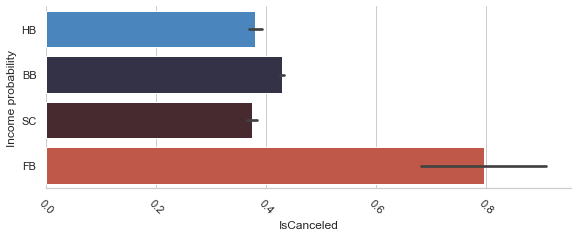

In [21]:
weight_of_variable(data,"Meal",target)

#### Notations:
The probability that customers who chose Full-Board as their meal obtion is the highest amongst all. However, the number of the FB is very small in comparision with the other 3 options given. While Half-board and Undefined is relatively the same, the people with Bed-Breakfast is slightly higher

### Will deposit reduced the probability of canceled bookings?

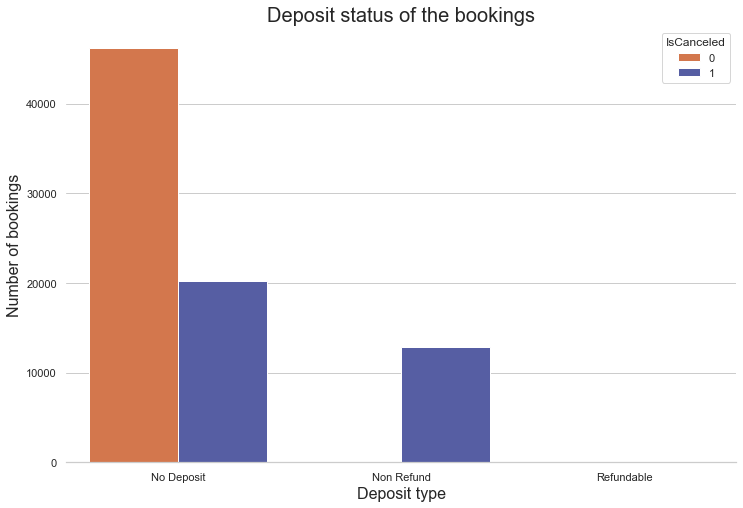

In [93]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=data, x="DepositType", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)])
sns.despine(left=True)
plt.title("Deposit status of the bookings", fontsize=20)
plt.xlabel("Deposit type", fontsize=16)
#plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

### Do the customers likely to return to the hotel?

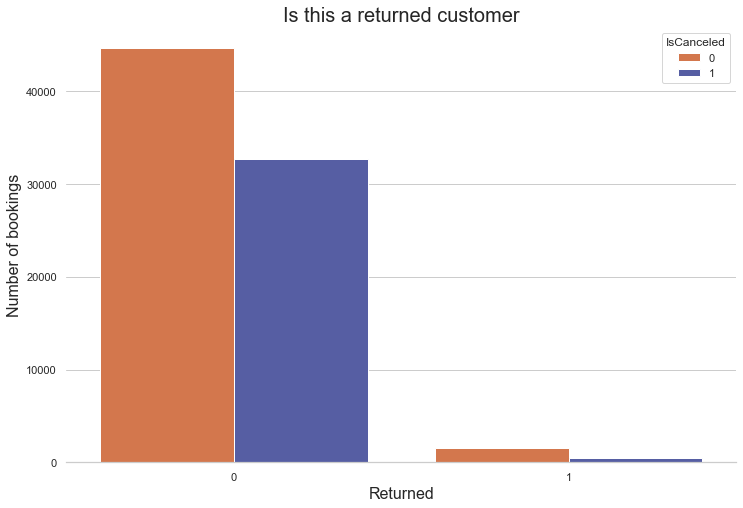

In [96]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=data, x="IsRepeatedGuest", hue="IsCanceled",
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)])
sns.despine(left=True)
plt.title("Is this a returned customer", fontsize=20)
plt.xlabel("Returned", fontsize=16)
#plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

Most of the bookings is from new customer, which might means that customer is not likely to return to the hotel after staying. This can be interpreted that this hotel is in the city which attract 1-time tourist and businessmans.

### `MarketSegment`

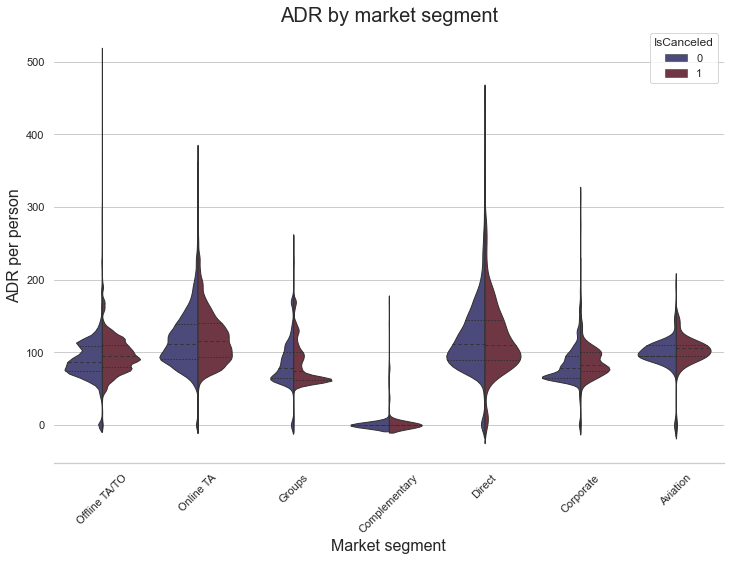

In [33]:
# show figure:
plt.figure(figsize=(12, 8))
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=data, x="MarketSegment", y="ADR", hue="IsCanceled",
               split=True, inner="quart", linewidth=1,
               palette='icefire')
sns.despine(left=True)
plt.title("ADR by market segment", fontsize=20)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person", fontsize=16)
plt.legend(title = "IsCanceled",loc="upper right")
plt.show()

### DistributionChannel

,Total count,Cancelled count,Weight
TA/TO,68928,31028,0.450151
Direct,6778,1231,0.181617
Corporate,3400,779,0.229118
GDS,193,37,0.191710


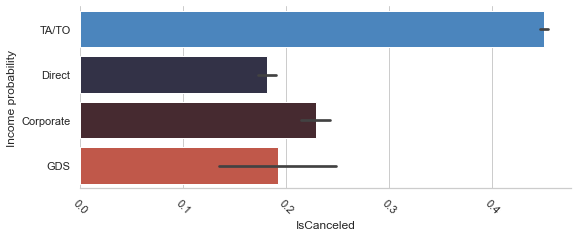

In [97]:
weight_of_variable(data,"DistributionChannel",target)

### ReservedRoomType

,Total count,Cancelled count,Weight
A,62577,27233,0.435192
D,11767,4147,0.352426
F,1791,700,0.390843
E,1553,505,0.325177
B,1111,364,0.327633
G,484,119,0.245868
C,14,5,0.357143
P,2,2,1.000000


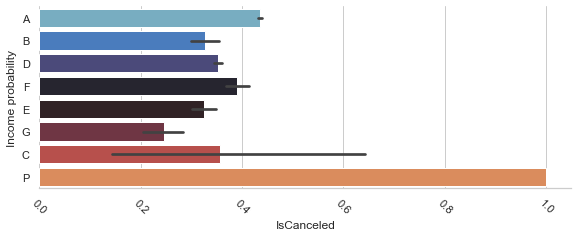

In [98]:
weight_of_variable(data,"ReservedRoomType",target)

### Check for multivariate corellation

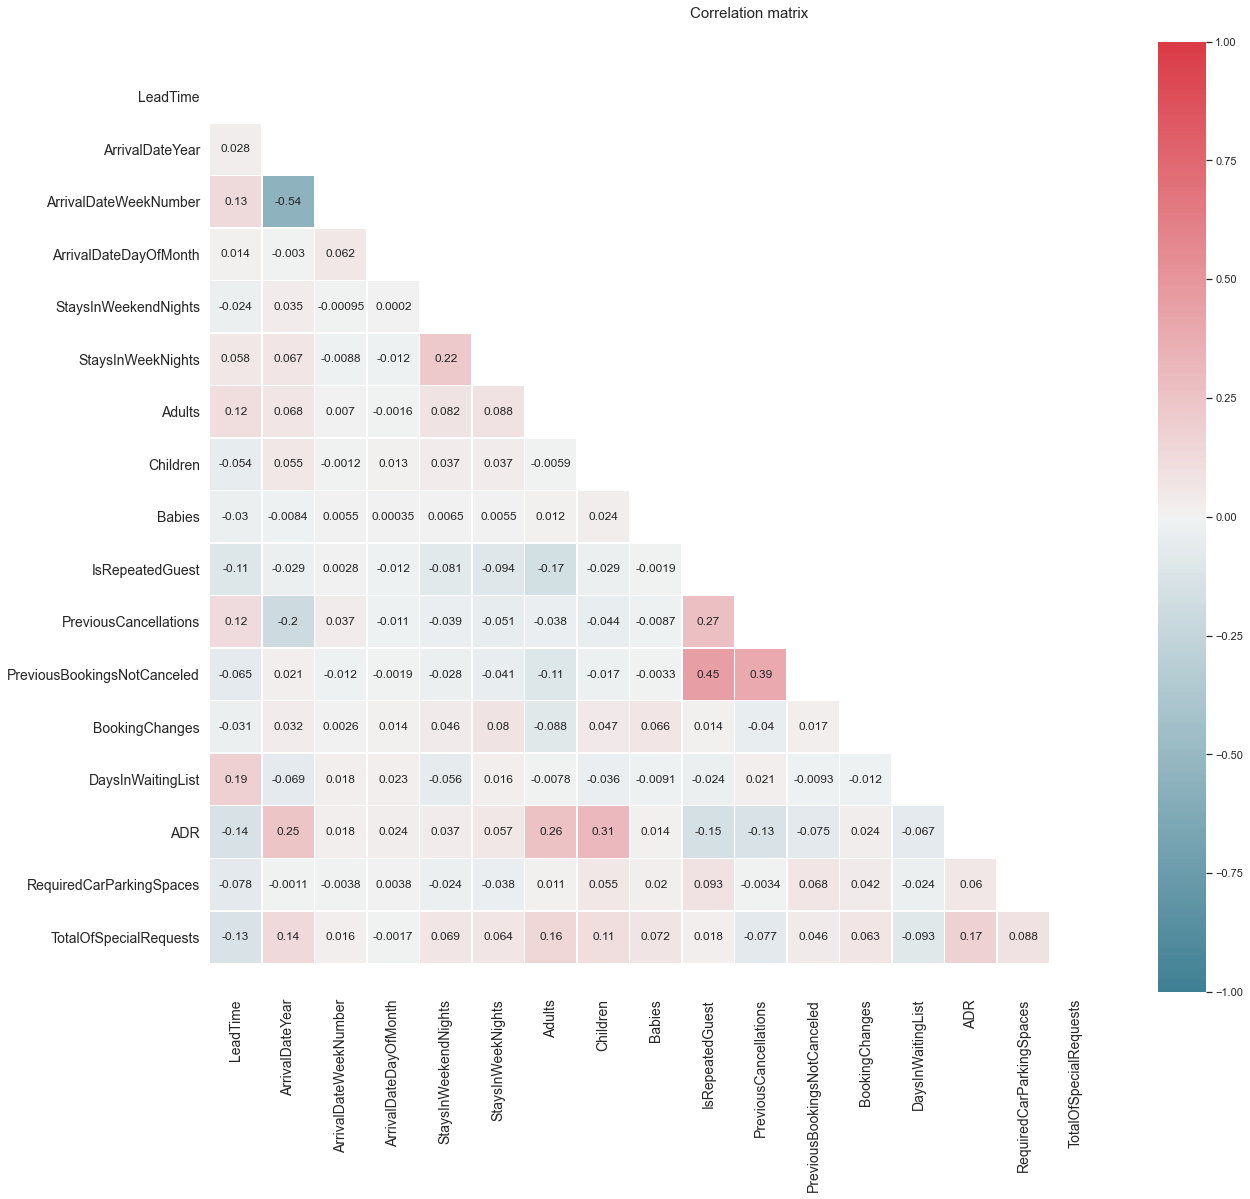

In [24]:
corrheatmap(data[numeric_feats], method = 'pearson')

# 3. Data preprocessing <a class="anchor" id="3"></a>

In [25]:
data.describe(exclude=[np.number])

,ArrivalDateMonth,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,ReservationStatusDate
count,79302,79302,79302,79302,79302,79302,79302,79302,79302,79302,79302,79302,79302
unique,12,4,166,7,4,8,9,3,224,207,4,3,864
top,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Check-Out,2015-10-21
freq,8979,62285,30956,38747,68930,62579,56991,66428,31954,75621,59382,46226,1416


### Data Transformation

In [53]:
# Box-cox transformation
def box_cox(df, columns):
    df_tf = df.copy()
    t_boxcox = PowerTransformer(method='box-cox')
    df_tf[columns] = pd.DataFrame(t_boxcox.fit_transform(df_tf[columns]+1), columns=columns,index = df_tf.index)    
    return df_tf

In [28]:
feats_to_transform = ['PreviousCancellations','PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList']

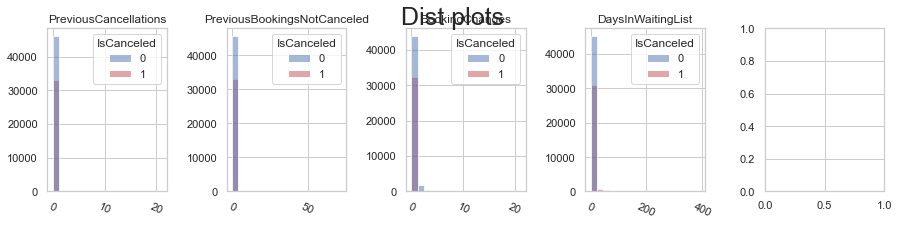

In [29]:
displot_all(data,np.array(feats_to_transform),target=target)  

In [30]:
df_tf = box_cox(data,feats_to_transform)

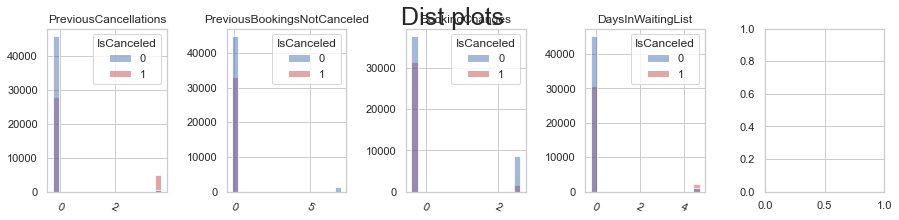

In [31]:
displot_all(df_tf,np.array(feats_to_transform),target=target)  

## 4. Predictive Modelling:

In [48]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('_________________________________________________________________________________________')
    print('                                       TRAIN                                          ')
    print('-----------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train,digits=4))
    print(confusion_matrix(y_train, pred_train))


    print('__________________________________________________________________________________________')
    print('                                      VALIDATION                                          ')
    print('------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val,digits=4))
    print(confusion_matrix(y_val, pred_val))
def enc_scl_pipe(X_train, y_train, X_test, enc_method, scaler = StandardScaler()): 
    X_train_encoded = X_train.copy()
    X_test_encoded= X_test.copy()
    # Set up feature to encode
    feature_to_encode = X_train.columns[X_train.dtypes == 'O'].tolist()
    
    if enc_method == 'label':
        for feat in feature_to_encode:
            # Initia the encoder model
            lbEncoder = LabelEncoder()
            # fit the train data
            lbEncoder.fit(X_train[feat])

            # transform training set
            X_train_encoded[feat] = lbEncoder.transform(X_train[feat])
            # transform test set
            X_test_encoded[feat] = lbEncoder.transform(X_test[feat])
            
    elif enc_method == 'glmm':
        # Initia the encoder model
        GLMMEncoder = ce.glmm.GLMMEncoder(verbose =0 ,binomial_target=True)
        # fit the train data
        GLMMEncoder.fit(X_train[feature_to_encode],y_train)
        # transform training set
        X_train_encoded[feature_to_encode] = GLMMEncoder.transform(X_train[feature_to_encode])
        # transform test set
        X_test_encoded[feature_to_encode] = GLMMEncoder.transform(X_test[feature_to_encode])
    else:
        raise 'No encoding method stated'
        
    # fit the scaler                    
    scaler.fit(X_train_encoded)
    # transform training set
    X_train_scaled = pd.DataFrame(scaler.transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
    # transform test set
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)
    
    return X_train_scaled, X_test_scaled, (GLMMEncoder, scaler)

def model_fit(model, model_name, X_train, y_train, X_test, y_test,  scores):
    '''This function is for training and measure the executed time of each model'''
    begin = time.perf_counter()
    model.fit(X_train, y_train)
    # Run cross-validation on training set
    train_score = accuracy_score(y_train, model.predict(X_train))
    test_score = accuracy_score(y_test, model.predict(X_test))
    # finish counting time
    end = time.perf_counter()
    # assign infomation
    scores[model_name] = [train_score, test_score ,round(end-begin,3)]
    return model, scores

In [49]:
#From EDA, we have chosen features not to used:
train = data.drop(columns=['ReservationStatus','ReservationStatusDate','IsCanceled'])
target = data.loc[:,'IsCanceled']

In [57]:
lgb_params = { 'colsample_bytree': 0.3,
                 'subsample': 0.9,
                 'learning_rate': 0.05,
                 'max_depth': 9,
                 'num_leaves': 60,
                 'min_child_samples': 285,
                 'random_state': 2,
                 'verbose':-1,
                 'n_estimators': 2000,                 
                 'cat_smooth': 39}

In [59]:
scores = {}
models = [(LogisticRegression(), 'Logistics Regression'),
          (lgb.LGBMClassifier(boosting_type='gbdt',random_state = 2),'LightGBM_baseline'),
          (lgb.LGBMClassifier(boosting_type='gbdt',**lgb_params), 'LightGBM_tuned'),
          (RandomForestClassifier(), 'Random Forest')]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3,  random_state=2)
X_train, X_test, _ =  enc_scl_pipe(X_train, y_train, X_test, enc_method='glmm', scaler=StandardScaler())
for model, name in models:    
    _ , scores = model_fit(model, name, X_train, y_train, X_test, y_test,  scores)    

#Now test the transformation result:
#train_tf = box_cox(train,feats_to_transform)
#target = data.loc[:,'IsCanceled']  
#Split the dataset
#X_train, X_test, y_train, y_test = train_test_split(train_tf, target, test_size=0.3,  random_state=2)
#X_train, X_test, (GLMMEncoder,STDscaler) =  enc_scl_pipe(X_train, y_train, X_test, enc_method='glmm', scaler=RobustScaler())   
#train
#_ , scores = model_fit(lgb.LGBMClassifier(boosting_type='gbdt',random_state = 2),'LightGBM_base_transform',
 #                      X_train, y_train, X_test, y_test, scores)    

final_score = pd.DataFrame.from_dict(scores, orient='index',columns=['Train','Test','Training time'])

In [60]:
final_score

,Train,Test,Training time
Logistics Regression,0.812301,0.810887,0.297
LightGBM_baseline,0.879821,0.872509,0.553
LightGBM_tuned,0.925652,0.882135,10.061
Random Forest,0.995586,0.890626,7.116


In [37]:
model = lgb.LGBMClassifier(boosting_type='gbdt',**lgb_params)
model.fit(X_train,y_train)

LGBMClassifier(cat_smooth=39, colsample_bytree=0.3, learning_rate=0.05,
               max_depth=5, metric='rmse', min_child_samples=285,
               n_estimators=2000, num_leaves=30, random_state=2, subsample=0.8,
               verbose=-1)

In [42]:
metrics(y_train, model.predict(X_train.loc[:,:]), y_test, model.predict(X_test.loc[:,:]))

_________________________________________________________________________________________
                                       TRAIN                                          
-----------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8965    0.9280    0.9120     32393
           1     0.8939    0.8499    0.8714     23117

    accuracy                         0.8955     55510
   macro avg     0.8952    0.8890    0.8917     55510
weighted avg     0.8954    0.8955    0.8951     55510

[[30061  2332]
 [ 3469 19648]]
__________________________________________________________________________________________
                                      VALIDATION                                          
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8782    0.9117    0.8946    

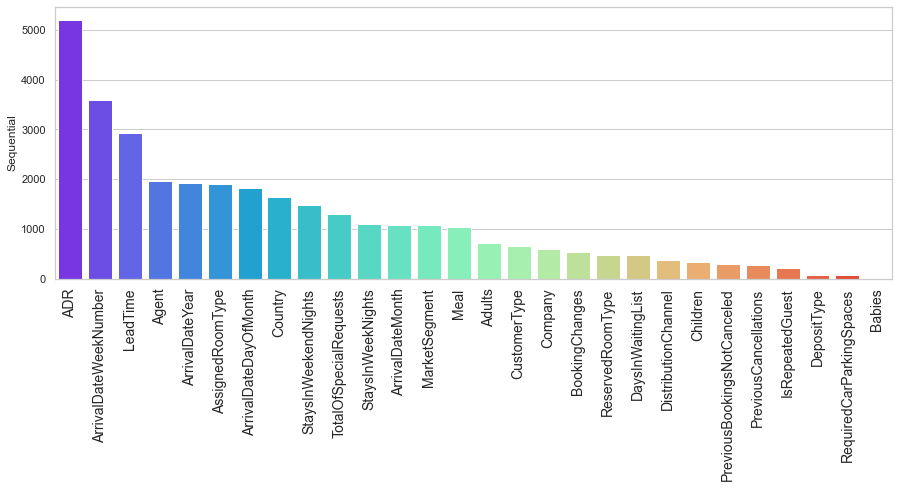

In [45]:
feats_imp = pd.Series(data = model.feature_importances_,index = X_train.columns)
feats_imp.sort_values(ascending=False,inplace=True)

fig,ax = plt.subplots(figsize=(15, 5), sharex=True)
# Generate some sequential data
sns.barplot(y=feats_imp.values, x= feats_imp.index, palette="rainbow", ax=ax,)
ax.set_ylabel("Sequential")
plt.xticks(rotation=90, fontsize = 14)
plt.show()

To be more practical in the deployment of the model, we also build an API to test the model prediction on new customer to know which cluster they belong to

[6, 2015, 'July', 27, 1, 0, 2, 1, 0.0, 0, 'HB', 'PRT', 'Offline TA/TO', 'TA/TO', 0, 0, 0, 'A', 'A', 0, 'No Deposit', '6', 'NULL', 0, 'Transient', 0.0, 0, 0]

In [164]:
#Prepare model for the api
train_encoded = train.copy()
# Saving  encoder
feature_to_encode = train.columns[train.dtypes == 'O'].tolist()
# Initia the encoder model
GLMMEncoder = ce.glmm.GLMMEncoder(verbose =0 ,binomial_target=True)
# fit the train data
GLMMEncoder.fit(train_encoded[feature_to_encode],target)
train_encoded[feature_to_encode] = GLMMEncoder.transform(train[feature_to_encode])
# fit the scaler     
scaler = StandardScaler()
scaler.fit(train_encoded)
# transform training set
train_encoded_scl = pd.DataFrame(scaler.transform(train_encoded), columns=train_encoded.columns, index=train_encoded.index)
#
#train_encoded_scl = box_cox(train_encoded_scl,feats_to_transform)
#final
model = lgb.LGBMClassifier(boosting_type='gbdt',**lgb_params)
model.fit(train_encoded_scl,target)   

LGBMClassifier(cat_smooth=39, colsample_bytree=0.3, learning_rate=0.05,
               max_depth=5, metric='rmse', min_child_samples=285,
               n_estimators=2000, num_leaves=30, random_state=2, subsample=0.8,
               verbose=-1)

In [173]:
test_id = 2
PROJECT_ROOT = Path(os.path.abspath('')).resolve()
out_path = os.path.join(PROJECT_ROOT, 'app','model')

dump(scaler, os.path.join(out_path, 'scaler{}.joblib'.format(test_id)))
#encoder
encoder = GLMMEncoder
dump(encoder, os.path.join(out_path, 'encoder{}.joblib'.format(test_id)))
# Saving best model
best_dt = model
dump(best_dt, os.path.join(out_path, 'best_lgbm{}.joblib'.format(test_id)))

['C:\\Users\\Admin\\Documents\\0.DSAA2020\\Jupyter Notebook\\Business Case\\Case 2\\app\\model\\best_lgbm2.joblib']

- Good: 6,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.0,0,0
- Canceled: 88,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.5,0,1

## 5. Evaluation

### Evaluate results
The proposed model (K-means clustering) has performed a good result in both clusters size and R2 score, which tell that the models is good in classify different customer segments. The defined clusters show distinctive values in most of the features.

For better understanding the clusters, a decision tree model is created to re-classify the dataset. The prediction result on testset (30% of the dataset) is 91% which is a very good result. 

Features importance are measured and the two features showing huge discriminative ability is `Dryed` and `Age`, follow by less significant features such as `Perdeal`, `LTV` and `Avr_purchase`.

### Review process
Major steps conducted in the project:
- Feature engineering: `Avr_purchase` = `Monetary` / `Freq`
- Data transformation: Box-cox transformation
- Data normalization: Standard scaler
- Clustering: K-means algorithm
- Classification/ Predictive model: Decision Tree Classifier

All the steps are conducted successfully and contribute to the final result

We will proceed to deploy the proposed model as it already satisfies the business goals and the data mining goals.

## 6. Deployment:
Deployment is a crucial part of every business project. A machine learning model will not be able to drive values if it is not effectively deployed in the real-world context.


### Plan deployment
The dataset collected by IT department is in a very good condition as no missing value and data error was found during the exploratory process. However, to ensure the quality of the predictive model in future use as well as scalability of the clustering model if there are more data fed in, any newly collected data should have the same quality as the current one.

To test the deployment, we also create an API to predict the belonging cluster of any new customer.

Current objective achieved:
- Cluster analysis: The first result of the project is a cluster analysis with insightful information about each customer segments to support on marketing activities. The clusters are well defined with detailed profiling carried out to understand the key features and characteristics that distinguish each cluster from the others
- Predictive model and testing environment: The second objective is to deliver a predictive model that able to classify the segment of any current customer or predict that of any future customer with high accuracy. To test the deployment, we also create an API to predict the belonging cluster of any new customer. The API is currently under testing platform but the aim of it is to carry out a practical approach for any business stakeholder to easily understand the result of the project.

[**Test on API**]
- "Wine Explorer": `653,55,20,78473,0,0,20,18,826,445,7,67,4,26,2,1,1,36,5,0,0,0,0,0,0,0,0,0`
- "Wine Expert": `666,18,12,27984,1,0,4,56,39,-7,88,4,29,14,32,21,48,60,8,0,0,0,0,0,0,0,0,0`
- "Red Lover": `1049,42,16,61748,1,1,2,46,37,-6,70,86,1,11,1,1,55,59,7,0,0,0,0,0,0,0,1,1`

### Plan monitoring and maintenance
Future steps to successfully deploy the model:
- Develop fully functioned application: the final solution that able to be scale up to all the organization. The application should be able to allow continuous data fed in, continuous training and evaluation. The application will accept new data for prediction and validated results of new data as additional training data.
- Periodical maintenance plan should be able to continuous evaluate key metrics of the cluster analysis objectives which is, for example, the successful of marketing plan suggested by the analysis or new customer achieved through the findings.


### Produce final report and presentation
Will be introduce at the project presentation
